# Nutrition NLP: joining 2 distinct datasets

<div class="alert alert-block alert-info">
Intro: Having access to a supermarket dataset gives us a unique occasion to get crucial insights into alimentary habits of consumers: the goal of this section is thus to isolate food-related items of the dunnhumby dataset and link it with a nutrition database of the U.S Department of Agriculture (USDA) in order to later build a nutrition profile of each household.
</div>

<div class="alert alert-block alert-info">
Method: This challenge appears to be a NLP task: the main challenge consists in joining the dunnhumby dataset with the USDA one, knowing that each food item would have a similar, but crucially non equal name. Thus, one has to infere the true nature of eacch food-item based on its name exclusively.
</div>

In [1]:
%matplotlib inline
import re
import os
import nltk
import time
import pickle
import sys

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator
from IPython.core.display import SVG

sys.path.insert(1, './utilities/')
from health_functions import *
%load_ext autoreload
%autoreload 2

In [2]:
DUNNHUMBY_PATH = '../data/dunnhumby_data/'
HEALTH_PATH = '../data/health'

## Import Data

In [3]:
products_df = pd.read_csv('../data/dunnhumby_data/product.csv')
transaction_data_df = pd.read_csv('../data/dunnhumby_data/transaction_data.csv')
    
# link the nutrient id with its name
nutrient_df = pd.read_csv('../data/health//nutrient.csv')
# contains the food articles name and their id test commi
food_df = pd.read_csv('../data/health/food.csv')
# contains the nutrients for each food article
food_nutrients_df = pd.read_csv('../data/health/food_nutrient.csv')
# linke the food articles ids to their category
food_category_df = pd.read_csv('../data/health/food_category.csv')


In [4]:
# We groupby the COMODITY DESC and SUB in order to have unique items names. Convention: keep the min id, max size of product for
products_df = products_df.groupby(['COMMODITY_DESC','SUB_COMMODITY_DESC'])\
           .agg({'PRODUCT_ID':'min','CURR_SIZE_OF_PRODUCT':'max','DEPARTMENT': 'min'})\
           .reset_index()\

## Dunnhumby Data

<div class="alert alert-block alert-info">
The dunnhumby dataset contains extensively items that have been sold a very low number of times,as shown earlier. We thus limit ourself to treat exclusively the dunnhumby products that are food-related: the columns "SUB_COMMODITY_DESC" is used as the source of information for the ingredients of the product and assembled in a single parsed column "ingredients"
</div>

In [5]:
#select only the categories which are food related, join them with the >1000 sold items and sort them
food_related = np.array(['NUTRITION','GROCERY','PASTRY','MEAT-PCKGD','SEAFOOD-PCKGD','PRODUCE','DELI','MEAT','SALAD BAR','GRO BAKERY','FROZEN GROCERY','SPIRITS','RESTAURANT'])

food_product_df = products_df.loc[(products_df['DEPARTMENT'].isin(food_related))].copy()
food_product_df = food_product_df[~food_product_df.COMMODITY_DESC.isin(['PAPER TOWELS','BATH TISSUES','LAUNDRY DETERGENTS','FD WRAPS/BAGS/TRSH BG']) ]

food_product_df['dunn_name'] = food_product_df.COMMODITY_DESC + " " + food_product_df.SUB_COMMODITY_DESC

food_product_df['comm_ing'] = food_product_df.COMMODITY_DESC.apply(parse_words_comm)

food_product_df['subcomm_ing'] = food_product_df.SUB_COMMODITY_DESC.apply(parse_words)

f = lambda x: x[0] + x[1]
food_product_df['dunn_ingredients'] = food_product_df[['comm_ing','subcomm_ing']].apply(f,axis = 1)
food_product_df.drop(columns = ['comm_ing','subcomm_ing'],inplace = True)


## Downloaded food nutrients data

<div class="alert alert-block alert-info">
The names of each dataset (Dunnhumby and USDA) need to get parsed properly in order to be compared: this is done using functionalities of nltk library along with a stemmer.
    
The food_nutrients_df dataframe gets processed such that we have the fdc_id vs the nutriments as columns (by joining it with nutrient_df)
</div>

In [6]:
#drop unnecessary columns and rename to be more understandable
food_nutrients_df.drop(["data_points","min","max","median","footnote","min_year_acquired","derivation_id"]\
                       ,axis=1,inplace=True)
nutrient_df.drop(["nutrient_nbr","rank"],axis=1,inplace=True)
food_category_df.drop(["code"],axis=1,inplace=True)
food_df.drop(["publication_date"],axis=1,inplace=True)

food_category_df.rename(columns={'id':'food_category_id','description':'category'},inplace= True)
food_df.rename(columns = {'description':'nut_name'},inplace = True)
#filter out only the necessary food nutrients since we have 227, 
#a lot of which aren't necessary to determine if a food is healthy
list_relevant_nutrients = ["Protein", "Total Carbohydrate","Total lipid (fat)","Sucrose",\
                            "Glucose (dextrose)","Sugars, total including NLEA","Fatty acids, total monounsaturated",\
                            "Fatty acids, total polyunsaturated","Fatty acids, total trans",\
                           "Fatty acids, total saturated","Cholesterol","Vitamin E, added",\
                           "Vitamin K (phylloquinone)","Vitamin B-12","Vitamin B-6",\
                            "Vitamin D","Vitamin A, RAE","Sodium, Na","Total fat (NLEA)","Fiber, total dietary",\
                           "Energy","Carbohydrate, by summation","Fructose"]

nutrient_df = nutrient_df[nutrient_df.name.isin(list_relevant_nutrients)].copy()
#simplify and normalize the nutrient names
simplified_names = nutrient_df.name.apply(trim_nutrient_name)
nutrient_df.loc[:,"name"] = simplified_names
nutrient_df.to_pickle('../results/nutriments_units.pickle')

#add the names of the nutrients contained in the food
food_nutrients_df = food_nutrients_df.join(nutrient_df.set_index('id'),on='nutrient_id',how='inner')

#energy is duplicated because we have both kcal and kj, we take only kcal
food_nutrients_df = food_nutrients_df.pivot_table(index='fdc_id', columns='name', values='amount',aggfunc='first')\
                                     .fillna(value=0)\
                                     .reset_index()

#add categories to the food df
food_df = food_df.join(food_category_df.set_index("food_category_id"),on="food_category_id",how="left")\
                 .drop(["food_category_id","data_type"],axis=1)

food_df['nut_ingredients'] = food_df.nut_name.apply(parse_words)
food_df.drop(columns = ['category'],inplace = True)

<div class="alert alert-block alert-info">
At this stage 2 dataframes are useful for what follows (fdc_id describes the index of the USDA dataset):
    
 - food_df = fdc_id vs parsed food title (list of string)
 - food_nutrients_df = fdc_id vs nutrients contained as columns
</div>

## Word Importance

<div class="alert alert-block alert-info">
We now filter the words according to their importance: that is, a word is more important as it apears many times in both datasets: (Ex: 'orange' is more important than 'artificial'). In order to do so, we need to first extract the words present in each dataset.
</div>

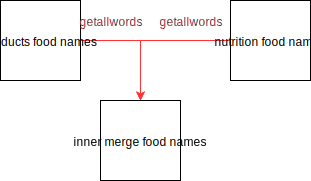

In [7]:
SVG(filename='graphs/allwords.svg')

In [9]:
#all words present in the nutrition dataset
all_words_nutrition = get_allwords(food_df.nut_ingredients)

#all words present in the product dataset
all_words_supermarket = get_allwords(food_product_df.dunn_ingredients)

### Obtaining words importance:

<div class="alert alert-success" role="alert">
Score algorithm: 
    
We check which words occur in both dataframes: only these words will have importance in determining the true nature of the food article we are dealing with
* As a parsed word appears in the "food.n.02" dataset of NLTK it gets a score of 1, otherwise of 0
* We add up the max-normalized occurence of the word in the dunnhumby dataset: this way, the max possible score is 2.
    
Overall, word which (1)are ingredients word and (2) tend to occur often get higher scores.
</div>

In [10]:
common_words = pd.merge(all_words_supermarket,all_words_nutrition,left_on = 'name',right_on = 'name',suffixes=('_supermarket', '_nutrition'))

In [12]:
print("Number of common words:{}".format(common_words.size))
common_words.head(10)

Number of common words:1497


,name,number_supermarket,number_nutrition
0,meat,73,400
1,food,73,284
2,juic,71,112
3,snack,55,40
4,drink,48,155
5,sauc,46,583
6,chees,46,534
7,cooki,44,110
8,bread,43,260
9,organ,42,9


In [15]:
DIC_SCORE = construct_dic_score(common_words)

<div class="alert alert-block alert-info">
DIC_SCORE links an importance score for each word.
</div>

## Application of the function

<div class="alert alert-block alert-info">
Now that we have the importance for each food word, we apply the following recursive algorithm, in order to find "matching" articles in the nutrient database for each article of the dunnhumby database.
We create the dataframe top_df wich associates the nutriments to every dunnhumby article, which was our initial goal.
</div>

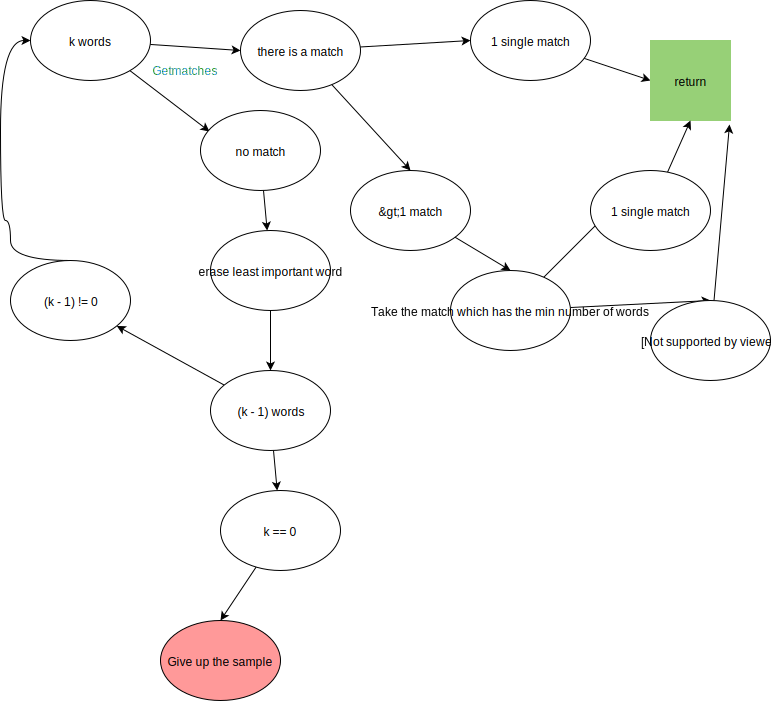

In [16]:
SVG(filename='graphs/Word_importance.svg')

In [17]:
print("Number items to match with the USDA dataset:{}".format(food_product_df.size))

Number items to match with the USDA dataset:14231


<div class="alert alert-block alert-info">
One can easily test the algorithm with some test food of its choice here.
</div>

In [23]:
test = ['Duck creamy swiss pudding 24 oz',
"Lettuce frozen",
"Peanuts Orange crisp","sandwich butter",
"lettuce cheese",
"indian Lamb 22 kg",
'vanilla creamy swiss miss pudding 24 oz',
"oriental noodles rice",
"vegetables", "ice cream bars",
"wolf chili without beans",
"tropical fruit bananas",
'vegetables green cut',
'vegetables shelf stable beans green fs whl cut',
"seafood shelf stable tuna",
"water"]

def f(x):
    print("Test article name: \t \t %s"%test[x])
    found_fdc_id = find_food(parse_words(test[x]), food_df, DIC_SCORE, verb = False)[1]
    if (found_fdc_id is not np.nan):
        print("Found corresponding item :\t %s" % food_df.set_index('fdc_id').loc[found_fdc_id].nut_name)
    else:
        print("Not found")
print('You can test the different articles here.')
interact(f, x=widgets.IntSlider(min=0, max=len(test) - 1, step=1, value=0));


You can test the different articles here.


interactive(children=(IntSlider(value=0, description='x', max=15), Output()), _dom_classes=('widget-interact',…

In [19]:
# the fdc id is the id of the food articles in the nutriment dataset: ref_fdc_id is the reference that an item of the product dataset needs which poibts on the corresponding article in the nutriment dataset
top_df = food_product_df.drop(columns = ['CURR_SIZE_OF_PRODUCT']).copy()
top_np = top_df.dunn_ingredients.to_numpy()
#we take the [1] since the id of the corresponding article is in the second result: the [0] is the name of the corresponding item
top_np_res = np.array([find_food(x,food_df,DIC_SCORE) for x in top_np])
nut_food_ing = top_np_res.T[0]
nut_food_ids = top_np_res.T[1]
top_df["ref_fdc_id"]  = nut_food_ids
top_df = top_df.join(food_df.set_index('fdc_id'),how = 'inner',on = 'ref_fdc_id')


top_df = top_df.merge(food_nutrients_df,how="left",left_on="ref_fdc_id",right_on="fdc_id",suffixes = ('','_y'))
top_df.drop(["ref_fdc_id","fdc_id","COMMODITY_DESC","SUB_COMMODITY_DESC"],axis=1,inplace=True)
top_df.set_index("PRODUCT_ID",inplace=True)


In [20]:
#saves results of this lengthy computation
top_df.to_pickle("../results/dunnhumb_articles_nutriments.pickle")
top_df.to_csv("../results/dunnhumb_articles_nutriments.csv")

<div class="alert alert-block alert-info">
We have established the link between the dunnhumby supermarket dataset and the food database from the Department of Food and Agriculture which provides the nutrients information. We can now begin our analysis
</div>